# Resnet152 with varying lr every 5 epochs
Accuracy at **87.56%** on test set

In [1]:
import pandas as pd
from pathlib import Path
from scipy.io import loadmat
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
train_path = 'data/train/'
cropped_path = 'data/cropped_train/'
test_path = 'data/test/'
all_img_path = 'data/all_img'
CROPPED_PATH = Path(cropped_path)

#### Commence training: Stage-1 (resnet152)
- Setting up data bunch and transformations

In [8]:
tfms = get_transforms()
trn_df_labels = train_df[['filename','class_name']]

src = (ImageList.from_df(trn_df_labels,train_path, cols='filename')
       .split_by_rand_pct(0.2, seed=42).label_from_df('class_name'))

In [9]:
data128 = (src.transform(tfms,size=128).databunch(bs=64).normalize(imagenet_stats))

In [10]:
learn = cnn_learner(data128,models.resnet152,metrics=[error_rate,accuracy, Precision(average='weighted'), Recall(average='weighted')])

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/jupyter/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:02<00:00, 88162751.79it/s]


In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-02


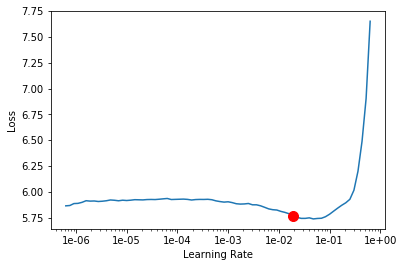

In [12]:
learn.recorder.plot(suggestion=True)

In [13]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,4.873180,4.859406,0.941032,0.058968,nan,0.058968,01:00
1,4.132984,3.936664,0.866708,0.133292,nan,0.133292,00:58
2,3.306090,3.048801,0.754300,0.245700,nan,0.245700,00:58
3,2.511158,2.081804,0.544226,0.455774,nan,0.455774,00:58
4,1.926842,1.813118,0.477887,0.522113,0.562765,0.522113,00:58


In [14]:
learn.save('2-stage1')

#### Stage-2
- Unfreezing the model to train body's weight

In [15]:
#Load the best model from stage-1
learn.load('2-stage1');

In [16]:
learn.unfreeze()

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


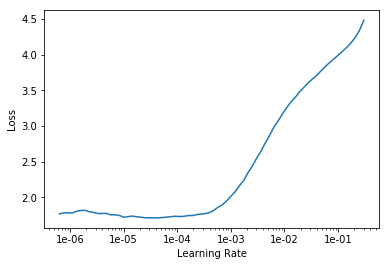

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,3e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,1.702032,1.763590,0.475430,0.524570,0.576790,0.524570,01:12
1,1.648375,1.666364,0.433047,0.566953,0.612326,0.566953,01:13
2,1.500812,1.569841,0.415848,0.584152,0.619872,0.584152,01:11
3,1.350143,1.505707,0.383907,0.616093,0.650090,0.616093,01:12
4,1.297982,1.500042,0.386364,0.613636,0.644276,0.613636,01:12


In [20]:
learn.save('2-stage2')

#### Stage-3
- Resizing the images to 224

In [52]:
learn.load('2-stage2');

In [53]:
data224= (src.transform(tfms,size=224).databunch(bs=32).normalize(imagenet_stats))

In [54]:
learn.data = data224

In [55]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


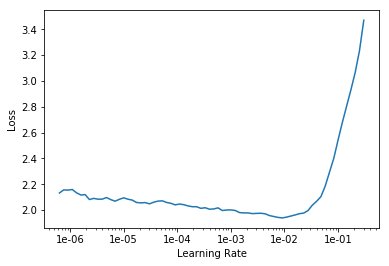

In [56]:
learn.lr_find()
learn.recorder.plot()

In [57]:
learn.fit_one_cycle(5,3e-3,wd=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,1.560786,1.515181,0.414005,0.585995,0.680108,0.585995,02:33
1,1.638768,1.663730,0.461302,0.538698,nan,0.538698,02:32
2,1.292581,1.165291,0.317568,0.682432,nan,0.682432,02:32
3,0.923526,0.846222,0.240172,0.759828,0.780555,0.759828,02:32
4,0.708160,0.802358,0.225430,0.774570,0.798715,0.774570,02:32


In [58]:
learn.save('2-stage3')

#### Stage-4
- Unfreezing the model for data sized 224

In [59]:
learn.load('2-stage3');

In [60]:
learn.unfreeze()

In [61]:
learn.lr_find(wd=0.01)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


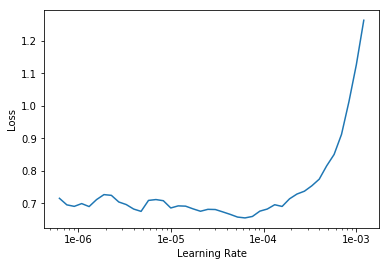

In [62]:
learn.recorder.plot()

In [63]:
learn.fit_one_cycle(5,slice(3e-6,1e-4),wd=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.670051,0.839080,0.232801,0.767199,0.788817,0.767199,03:17
1,0.732046,0.793195,0.227887,0.772113,0.799268,0.772113,03:19
2,0.584693,0.758300,0.220516,0.779484,0.802316,0.779484,03:19
3,0.501037,0.717374,0.202088,0.797912,0.819222,0.797912,03:19
4,0.452413,0.711701,0.205160,0.794840,0.816990,0.794840,03:19


In [64]:
learn.save('2-stage4')

#### Stage-5
- Last resizing to 299 

In [94]:
learn.load('2-stage4');

In [95]:
data299 = (src.transform(tfms,size=299).databunch(bs=8).normalize(imagenet_stats))

In [96]:
learn.data = data299

In [97]:
learn.freeze()

In [100]:
learn.lr_find(wd=0.01)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


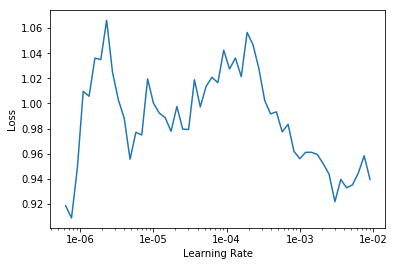

In [101]:
learn.recorder.plot()

In [102]:
learn.fit_one_cycle(5,1e-3,wd=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,1.023617,0.794199,0.234029,0.765971,0.797898,0.765971,05:26
1,1.109589,0.790716,0.226044,0.773956,0.808985,0.773956,05:25
2,0.989173,0.763505,0.213145,0.786855,0.812171,0.786855,05:25
3,0.770802,0.657012,0.183661,0.816339,0.840096,0.816339,05:24
4,0.585734,0.627786,0.179361,0.820639,0.836958,0.820639,05:24


In [103]:
learn.save('2-stage5')

#### Stage-6 
- Unfreezing and last 5 epochs 

In [104]:
learn.load('2-stage5');

In [105]:
learn.unfreeze()

In [106]:
learn.lr_find(wd=0.01)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


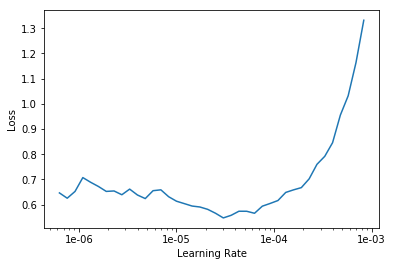

In [107]:
learn.recorder.plot()

In [108]:
learn.fit_one_cycle(5,slice(1e-5,5e-5), wd=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.812545,0.743243,0.210074,0.789926,0.816839,0.789926,07:17
1,0.969272,0.768474,0.220516,0.779484,0.813986,0.779484,07:19
2,0.771920,0.685980,0.193489,0.806511,0.836276,0.806511,07:18
3,0.591660,0.577976,0.159705,0.840295,0.856044,0.840295,07:18
4,0.523004,0.555415,0.156634,0.843366,0.856985,0.843366,07:18


In [109]:
learn.save('2-stage6')

In [ ]:
learn.load('2-stage6');

In [114]:
learn.bs = 16

In [115]:
learn.lr_find(wd=0.01)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


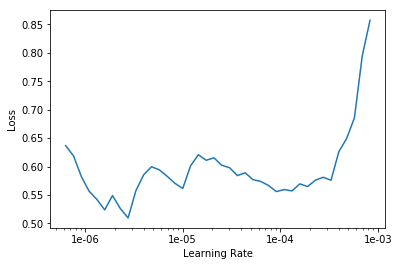

In [116]:
learn.recorder.plot()

In [117]:
learn.fit_one_cycle(5,slice(1e-6,1e-4),wd=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.471695,0.544691,0.148649,0.851351,0.872933,0.851351,07:19
1,0.499808,0.563355,0.154177,0.845823,0.863117,0.845823,07:19
2,0.460922,0.534416,0.146806,0.853194,0.868699,0.853194,07:19
3,0.362558,0.510326,0.136364,0.863636,0.878258,0.863636,07:20
4,0.304844,0.497777,0.131450,0.868550,0.881107,0.868550,07:19


In [118]:
learn.save('2-stage6.2')

### Test Set Performance

In [121]:
data_test = (ImageList.from_df(all_img_df,all_img_path,cols='filename')
           .split_from_df(col='test').label_from_df(cols='class_name').transform(tfms,size=299).databunch(bs=64).normalize(imagenet_stats))

In [122]:
learn.load('2-stage6.2');

In [123]:
learn.data = data_test

In [124]:
test_preds, test_ys = learn.TTA()

In [125]:
accuracy(test_preds,test_ys)

tensor(0.8756)

#### Accuracy is 87.56% with resnet152